# Local Active Learning

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Active Learning workflow for increasing the training data of a DNN. Incorporates an API to automatically generate FEM calculations with IDEA Statica. 

*Local* Active Learning refers to adding new load combinations to existing designs. The workflow is structured as follows:
1. Identify design, where the DNN has increased *uncertainty*, and/or *error*
2. Optimaly select new load combinations to be added to the identified designs
3. Calculate the load capacities with the API for the identified designs with the obtained load combinations
4. Add to the trainin data and finetune the DNN
5. Repeat 1-4 until satisfied

**IMPORTANT**: Change `idea_path` variable in `API.py` to the path of IDEA Statica

**Dependencies**: 
- `Datareader.py`
- `Settings.py`
- `DNN.py`
- `Saved Models\DNN_Model_Full_V2`
- `AL_API\API.py`
- `AL_API\Corner_Stiff_Wid.ideaCon`
- `AL_API\Corner_Stiff2_Wid.ideaCon`
- `AL_API\Corner.ideaCon`
- `AL_API\Corner_Stiffner.ideaCon`

**Generates**:
- `Data\Extended_Database.csv`
- `Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth`




## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math
import random
import time
import pickle

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
import torch

from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Extended_Database.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


### Load Forward Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization


### Generate (or load) data uncertainties

#### Generate

In [6]:
#mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)

In [7]:
#uncertainty_full = mcd_std_full / mcd_mean_full
#np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

#### Load

In [8]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

## Illustrate workflow

### 1. Find most uncertain profiles

In [9]:
most_uncertain_samples = np.argsort(uncertainty_full)[-10:]
df_most_uncertain = df_full.loc[most_uncertain_samples]

In [10]:
y_preds, _ = model.predict(df_full)
y_truths = df_full['target'].values

In [11]:
rel_error = (y_truths-y_preds.numpy().flatten())/ y_truths

In [12]:
most_error_samples = np.argsort(np.abs(rel_error))[-10:]
df_most_error = df_full.loc[most_error_samples]

In [13]:
uncertainty_full = rel_error

Define geometric & material features, which define a profile. (No loads)

In [14]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

Taking the most uncertain values is not a good strategy, since most of them will be from the same profile (different load combinations).

In [15]:
df_most_uncertain[fixed_features].duplicated(keep=False)

71617     True
71615     True
71965    False
71619     True
71553    False
74197     True
71616     True
74199     True
71618     True
71879    False
dtype: bool

Instead form groups according to the profile dimensions (identical geometry/material, different load combinations).

In [16]:
identical_groups = df[fixed_features].groupby(list(df[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
print(f"Number of identical groups: {len(identical_groups)}")

Number of identical groups: 152259


Get the max uncertainty for each group:

In [17]:
group_uncertainty = np.array([uncertainty_full[group].max() for group in identical_groups])

Get the n most uncertain groups:

In [18]:
most_uncertain_groups = np.argsort(group_uncertainty)[-10:]

Most uncertain group of profiles:

In [19]:
most_uncertain_group_ids = identical_groups[most_uncertain_groups[0]]

Select one profile of the group to serve as a template (does not matter which, since all have identical features):

In [20]:
base_id = most_uncertain_group_ids[0]
base_profile = df_full.iloc[base_id:base_id+1].copy()
group_profiles = df_full.iloc[most_uncertain_group_ids].copy()
group_uncertainty = uncertainty_full[most_uncertain_group_ids]

### 2. Get new load combination

Function to find the location (M/V contribution) of new load combinations, based on the location and uncertainty of existing points.

In [21]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    if uncertainty.max() - uncertainty.min() == 0:
        uncertainty_normalized = (uncertainty - uncertainty.min())
    else:
        uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)]

def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    return M_contribution, V_contribution

In [22]:
ratio = find_optimal_location(group_profiles['V_contribution'].values, group_uncertainty) # M or V needed?
M_contribution, V_contribution = get_MV_contribution(ratio)

new_profile = base_profile.copy()
new_profile['M_contribution'] = round(M_contribution,6)
new_profile['V_contribution'] = round(V_contribution,6)

print(f"Optimal ratio: {ratio}")
print(f"Optimal M_contribution: {M_contribution}")
print(f"Optimal V_contribution: {V_contribution}")

Optimal ratio: 0.48484848484848486
Optimal M_contribution: 0.7237340381050702
Optimal V_contribution: 0.6900790114821119


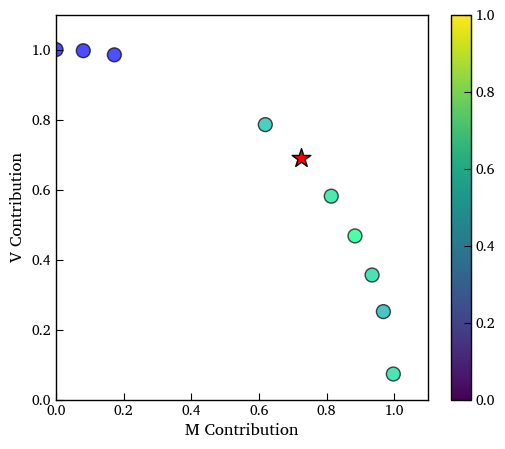

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M_contribution'], group_profiles['V_contribution'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M_contribution'], new_profile['V_contribution'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel('M Contribution')
plt.ylabel('V Contribution')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.colorbar()

plt.show()

In [24]:
current_id = len(df_full)

new_profile.index = [current_id]
new_profile['M_Rd'] = None
new_profile['V_Rd'] = None
new_profile['M'] = None
new_profile['V'] = None
new_profile['proz'] = None

This is the resulting profile. The geometric and material features are taken from the base profile (template), only the load combination is novel. 

In [25]:
new_profile

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,None,None,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,NaN


Convert `M_contribution`and `V_contribution`to loads $M$ and $V$:

In [26]:
def get_MV(profile):
    Mplx = profile['Mpl_x']
    Mply = profile['Mpl_y']
    Vplx = profile['Vpl_x']
    Vply = profile['Vpl_y']
    V_cont = profile['V_contribution']
    M_cont = profile['M_contribution']

    ratio = V_cont / (M_cont +1e-12)
    Vmax = np.max([Vplx, Vply])
    Mmax = np.max([Mplx, Mply])
    Mnorm = Mmax / Mply
    Vnorm = Vmax / Vply
    
    M = Vnorm / (ratio + Vnorm / Mnorm)
    V = ratio * M

    profile['M'] = M*Mply
    profile['V'] = V*Vply

In [27]:
get_MV(new_profile)

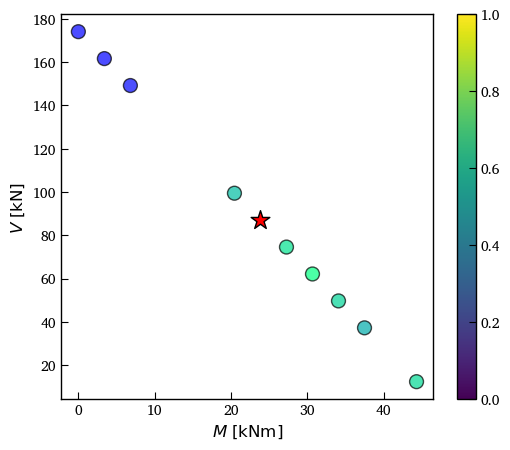

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M'], group_profiles['V'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M'], new_profile['V'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel(plot_params.feature_labels['M'])
plt.ylabel(plot_params.feature_labels['V'])

plt.colorbar()

plt.show()

### 3. Calculate Resistance with API

In [29]:
os.chdir(r"AL_API")
from API import IdeaConnectionClient

Absolute Paths are needed.

In [30]:
PATH = os.path.join(directory.root, "AL_API")
InputFileName = os.path.join(PATH,"Knee_widener_I_Output_red_Q4.parquet")

There are four idea templates. Depending on the existence of certain features, different templates have to be chosen. Depending on the lowest nonzero feature (see image), the according template is chosen.

<img src="templates.png" alt="image" width="600"/>

In [31]:
# All template names
ideatemplates_filenames = ['Corner.ideaCon',
                        'Corner_Stiffner.ideaCon',
                        'Corner_Stiff_Wid.ideaCon',
                        'Corner_Stiff2_Wid.ideaCon']

# Features that vary across templates
variable_features = ['t_stiffc',
                'h_wid',
                'b_wid',
                'd_wid',
                't_fwid',
                't_wwid',
                't_stiffb'
                ]

# How many variables each template has (e.g. Corner is the most simplest template and has 0 variable features)
existing_variable_features = {'Corner.ideaCon':0,
                              'Corner_Stiffner.ideaCon':1,
                              'Corner_Stiff_Wid.ideaCon':6,
                              'Corner_Stiff2_Wid.ideaCon':7}

existing_variable_features_indices = np.array(list(existing_variable_features.values()))

# Function to retrieve the ideal template based on the profile
def get_ideatemplate(profile):
    values = profile[variable_features].fillna(0).astype(float).values
    nonzero_indices = np.nonzero(values)[0]
    highest_nonzero_index = 0 if len(nonzero_indices) == 0 else np.max(nonzero_indices) + 1
    ideatemplate_id = np.nanargmin(np.abs(existing_variable_features_indices - highest_nonzero_index))
    return ideatemplates_filenames[ideatemplate_id]

Find the template for the considered profile and open it in IdeaStatica.

In [32]:
inputs = new_profile.copy()
ideatemplate = get_ideatemplate(inputs)
IdeaName = os.path.join(PATH,ideatemplate)

conn = IdeaConnectionClient()
conn.open(IdeaName)

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiffner.ideaCon


### 4. Prepare

Adjust the feature labeling and the unit scaling to match with IdeaStatica.

In [33]:
i=inputs.index[0]  
params = {
    'Prof_c': inputs.at[i, 'Profile_x'], 'Prof_b': inputs.at[i, 'Profile_y'],
    'steel_grade': inputs.at[i, 'Steel grade_x'], 'gamma': inputs.at[i, 'Gamma'], 
    'h_wid': inputs.at[i, 'h_wid']/1000, 'b_wid': inputs.at[i, 'b_wid']/1000,
    'd_wid': inputs.at[i, 'd_wid']/1000, 't_fwid': inputs.at[i, 't_fwid']/1000,
    't_wwid': inputs.at[i, 't_wwid']/1000, 
    't_stiffc': inputs.at[i, 't_stiffc']/1000, 't_stiffb': inputs.at[i, 't_stiffb']/1000,
    'offset': inputs.at[i, 'Offset']/1000  
}

Load parameters into IdeaStatice to build the profile.

In [34]:
conn.update_params_by_name(params)
if not conn.params_valid():
    raise Exception("Parameters validation failed.")

#### 5. Define Loads

Functions to adjust loads incrementely up (underloaded) or down (overloaded).

In [35]:
def overloaded(calculated,profiles,i):
    overload_counter=0
    while calculated == False:
        print('k =', overload_counter)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=0.9
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=0.9
        else:
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=0.9
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] ) 
        calculated = conn.calculate()
        overload_counter=(overload_counter+1)
        if overload_counter == 100:
            break
        
# In case of underload,, get in the loop and decrease the load:
def underloaded(applied_percentage,profiles,i):
    underload_counter=0
    while applied_percentage == 1:
        print('j =', underload_counter)
        print('Applied percentage =',applied_percentage)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=1.1
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=1.1
        else:    
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=1.3
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] )    
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,profiles,i)
        
        # Get the applied loads:
        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']
        underload_counter=(underload_counter+1)

    return results, loads, applied_percentage

In [36]:
loads = conn.get_loads()

loads[0]['forcesOnSegments'][1]['my'] = int(inputs.at[i,'M']*1000)
loads[0]['forcesOnSegments'][1]['qz'] = int(inputs.at[i,'V']*1000)#!!!!

conn.set_loads(loads) 
print('M=',loads[0]['forcesOnSegments'][1]['my'] )
print('V=',loads[0]['forcesOnSegments'][1]['qz'] )            

M= 23839
V= 87076


In [37]:
new_profile['M'] = inputs['M'].values[0]
new_profile['V'] = inputs['V'].values[0]

### 6. Calculate

Calculate ...

In [38]:
calculated = conn.calculate()

if calculated == False:
    overloaded(calculated, new_profile, new_profile.index[0])

Get results:

In [39]:
results = conn.get_results()
loads = conn.get_loads()
applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
if applied_percentage == 1:
    underloaded(applied_percentage,new_profile,new_profile.index[0])

applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

outputs = inputs.copy()

outputs.at[i, 'proz'] = applied_percentage
outputs.at[i, 'M_Rd'] = applied_M/1000 # [kNm]
outputs.at[i, 'V_Rd'] = applied_V/1000 # [kN]

cost = results['costEstimationResults']['totalEstimatedCost']
outputs.at[i, 'cost'] = cost

Final profile with calculate moment and shear resistance.

In [40]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,22.721547,82.994313,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,125.573642


Calculate the target value from the resulting moment and shear resistance.

In [41]:
def calculate_target_from_Rd(profile):
    profile['V_norm'] = abs(profile['V_Rd'] / profile['Vpl_y'])
    profile['M_norm'] = abs(profile['M_Rd'] / profile['Mpl_y'])
    profile['target'] = (profile['V_norm']**2 + profile['M_norm']**2)**0.5

In [42]:
calculate_target_from_Rd(outputs)

In [43]:
conn.close()

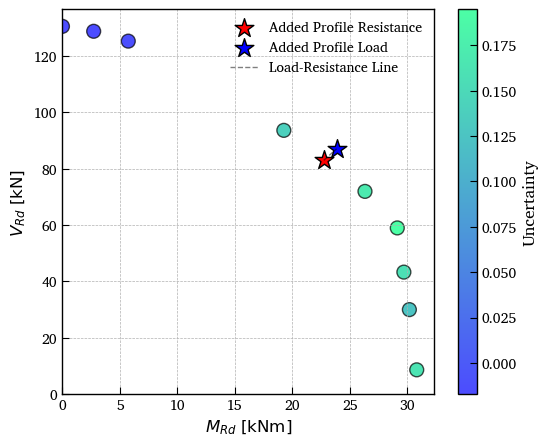

In [44]:
fig, ax = plt.subplots(figsize=(6,5))

sc = plt.scatter(df_full.loc[most_uncertain_group_ids]['M_Rd'].values,
            df_full.loc[most_uncertain_group_ids]['V_Rd'].values,
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(outputs['M_Rd'].values,
            outputs['V_Rd'].values,
            c='red', s=200, edgecolor='black', label='Added Profile Resistance', marker='*')

plt.scatter(outputs['M'],
            outputs['V'],
            c='blue', s=200, edgecolor='black', label='Added Profile Load', marker='*')

plt.plot((outputs['M_Rd'].values, outputs['M'].values),(outputs['V_Rd'].values, outputs['V'].values),
         color='black', linestyle='--', linewidth=1, alpha=0.5, label='Load-Resistance Line')

plt.xlabel(plot_params.feature_labels['M_Rd'])
plt.ylabel(plot_params.feature_labels['V_Rd'])

plt.legend()
plt.colorbar(sc,label='Uncertainty')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Local Active Learning

### Preperation

In [ ]:
model_AL = copy.deepcopy(model)
df_AL = df_full.copy()
df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

#### Define Learning Parameters

In [46]:
iterations = 1
groups_per_iter = 20
add_per_group = 2

finetuning_lr = model.config['learning_rate']
patience = 3

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 40
Added Samples: 40


In [47]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [48]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 10, 5)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 5
Total Epochs: 5


#### Define Save Options

In [47]:
save_interim_results = False

In [49]:
model_name = "DNN_Model_AL_Finetuned"
database_filename = "Extended_Database.csv"

MODEL_SAVE_PATH = os.path.join(directory.root, "Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

DATA_SAVE_FILE = os.path.join(directory.root, "Data", database_filename)

### Data Generation

#### Active Learning Loop

In [ ]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_AL)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            #print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        get_MV(new_profiles)

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in unique_templates:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,df_new_profiles,profile_id)
            end_time = time.time()

            df_new_profiles.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1.0:
                results, loads, applied_percentage = underloaded(applied_percentage,df_new_profiles,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save_interim_results:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)

*** Iteration 1/1 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 5867)
   Processing Group 5.00% (Group id: 12183)
   Processing Group 10.00% (Group id: 8884)
   Processing Group 15.00% (Group id: 1373)
   Processing Group 20.00% (Group id: 1616)
   Processing Group 25.00% (Group id: 6113)
   Processing Group 30.00% (Group id: 2783)
   Processing Group 35.00% (Group id: 2540)
   Processing Group 40.00% (Group id: 1853)
   Processing Group 45.00% (Group id: 3961)
   Processing Group 50.00% (Group id: 10138)
   Processing Group 55.00% (Group id: 1617)
   Processing Group 60.00% (Group id: 6787)
   Processing Group 65.00% (Group id: 4912)
   Processing Group 70.00% (Group id: 3247)
   Processing Group 75.00% (Group id: 13384)
   Processing Group 80.00% (Group id: 3486)
   Processing Group 85.00% (Group id: 14732)
   Processing Group 90.00% (Group id: 7744)
   Processing Group 95.00% (Group id: 10804)
Unique templates in this iteration: ['Corner_Stiffner.ideaCon' 'Corner_Stiff_

#### Save Dataframe

In [ ]:
df_AL.to_csv(DATA_SAVE_FILE, index=True)

#### Save Model

In [ ]:
model_AL.save(MODEL_SAVE_FILE)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Model saved to: Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth


### Load Dataframe & finetuned Model (given existing files)

In [51]:
directory.reset_root()
df_iter1 = pd.read_csv('Data\extended_profiles_iter_1.csv', index_col=0)
df_iter2 = pd.read_csv('Data\extended_profiles_iter_2.csv', index_col=0)
df_iter3 = pd.read_csv('Data\extended_profiles_iter_3.csv', index_col=0)
df_AL = pd.concat([df_AL, df_iter1, df_iter2, df_iter3], ignore_index=False)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [52]:
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [23]:
df_AL = pd.read_csv(DATA_SAVE_FILE)
model_AL = torch.load(MODEL_SAVE_FILE)
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

## Analysis of Results

### Model Performance

In [53]:
ids_added = np.array(list(df_AL.loc[len(df_full):].index))
ids_before = np.array(list(df_full.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds_before, _ = model.predict(df_AL)
y_truth_before = df_AL['target'].values

# Get Predictions after AL
y_preds_after, _ = model_AL.predict(df_AL)
y_truth_after = df_AL['target'].values

y_preds_after = y_preds_after.numpy().flatten()
y_preds_before = y_preds_before.numpy().flatten()

# Calculate relative error
error_before = np.abs((y_preds_before - y_truth_before) / y_truth_before+1e-8)
error_after = np.abs((y_preds_after[ids_before] - y_truth_after[ids_before]) / y_truth_after[ids_before]+1e-8)
error_added = np.abs((y_preds_after[ids_added] - y_truth_after[ids_added]) / y_truth_after[ids_added]+1e-8)

In [60]:
metrics_before = model.get_metrics()
metrics_after = model_AL.get_metrics()

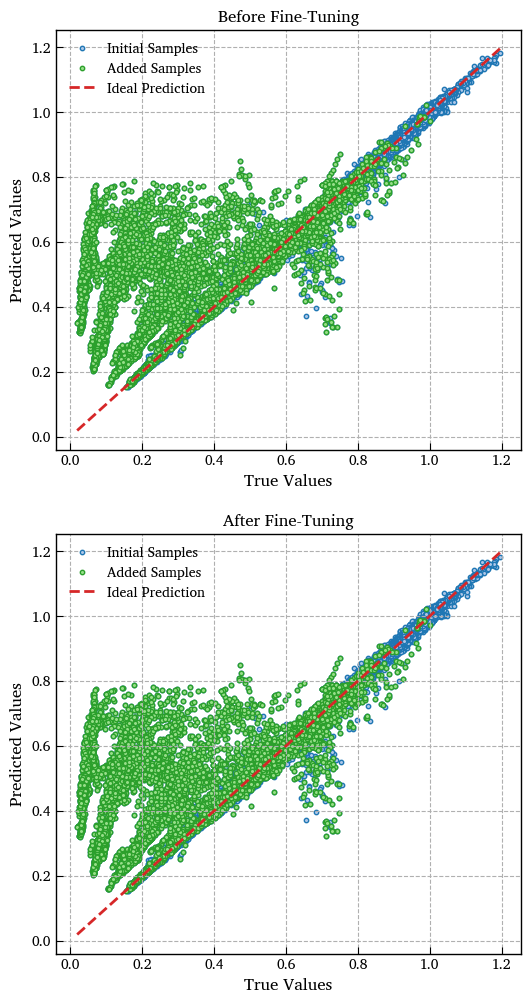

In [42]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

axs[0].scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=2
            )

axs[0].scatter(y_truth_before[ids_added], y_preds_before[ids_added],
               label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

axs[0].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[0].grid(True, linestyle='--', zorder=0)

axs[1].scatter(y_truth_after, y_preds_after, 
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10
            )

axs[1].scatter(y_truth_after[ids_added], y_preds_after[ids_added],
            label='Added Samples', 
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

axs[1].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[1].grid(True, linestyle='--', zorder=0)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Before Fine-Tuning')
axs[1].set_title('After Fine-Tuning')

axs[0].set_xlabel('True Values')
axs[1].set_xlabel('True Values')

axs[0].set_ylabel('Predicted Values')
axs[1].set_ylabel('Predicted Values')

plt.show()

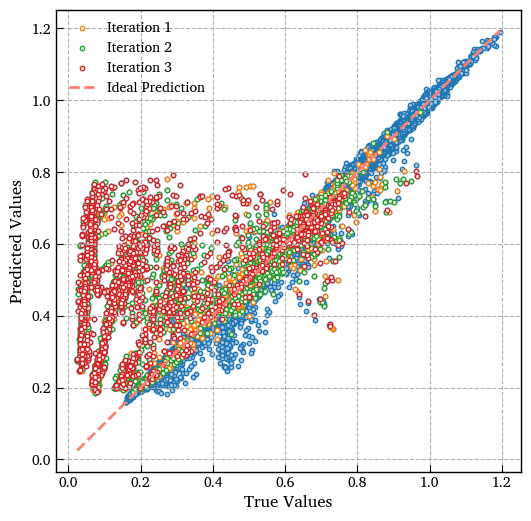

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_truth_after, y_preds_after, 
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            alpha=1.0
            )

for i in range(iterations):
    ax.scatter(y_truth_after[df_AL['iteration'] == i+1],
                y_preds_after[df_AL['iteration'] == i+1],
                label=f'Iteration {i+1}',
                facecolor='white',
                edgecolor=plot_params.morecolors[2*(i+1)],
                s=10,
                alpha=1.0
                )

ax.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

ax.grid(True, linestyle='--', zorder=0)
ax.legend()
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

plt.show()

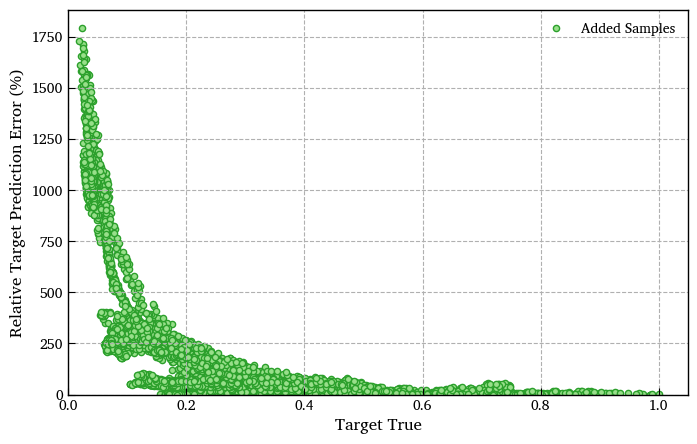

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(df_added['target'],error_added*100,
            label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=20
            )

plt.xlabel('Target True')
plt.ylabel('Relative Target Prediction Error (%)')
plt.legend()

plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True, linestyle='--', zorder=0)

plt.show()

### Loss Progression

Training and Validation Loss Spike

NameError: name 'epochs_per_iter' is not defined

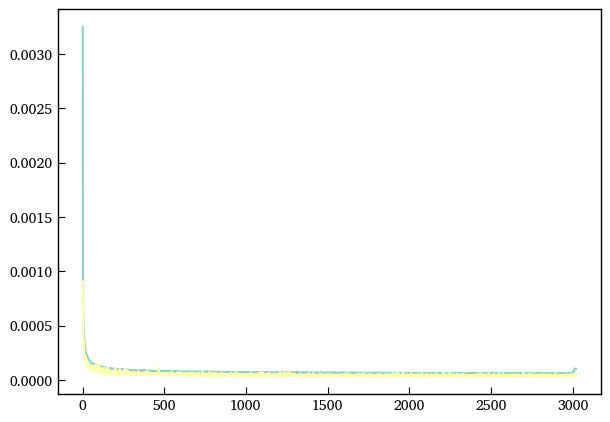

In [30]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model_AL.train_losses['total'], label='Training Loss', c=plot_params.colors[0],zorder=2)
plt.plot(model_AL.val_losses['total'], label='Validation Loss', c=plot_params.colors[1],zorder=2)

for i in range(iterations):
    iterations_start = model_AL.config['epochs'] + i * epochs_per_iter
    iterations_end = iterations_start + epochs_per_iter
    plt.axvline(x=iterations_start, color=plot_params.colors[2], linestyle='--',zorder=0)
    plt.axvline(x=iterations_end, color=plot_params.colors[2], linestyle='--',zorder=0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0.99*model.config['epochs'],model.config['epochs']+iterations*epochs_per_iter])
plt.yscale('log')
plt.legend()

### Features of Data Added

In [69]:
df_added = df_AL.loc[ids_added].copy()

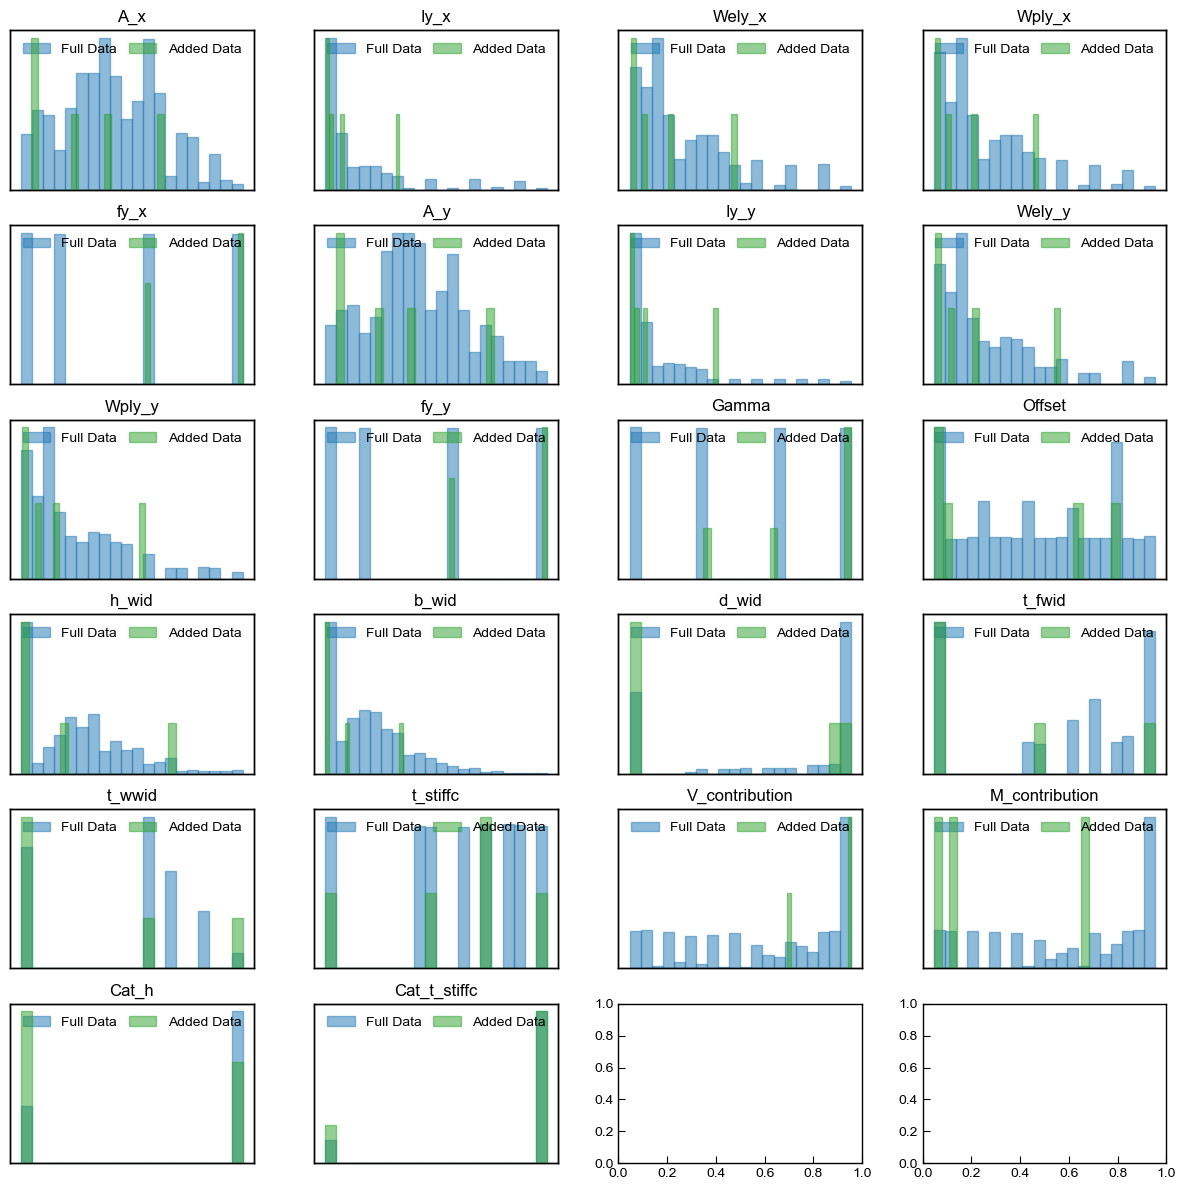

In [182]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_full[feature].values, bins=20, 
            edgecolor=plot_params.colors[0], 
            facecolor=plot_params.colors[0],
            alpha=0.5, label='Full Data')
    ax2.hist(df_added[feature].values, bins=20, 
             edgecolor=plot_params.colors[2],
             facecolor=plot_params.colors[2],
             alpha=0.5, label='Added Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Check added M-V location

In [54]:
def calculate_error(curve, points):
    curve = np.asarray(curve, dtype=float)
    points = np.atleast_2d(np.asarray(points, dtype=float))

    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    # Extracts the starting point of each segment — these are the anchors for the line segments.
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    # Scalar projection
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

In [55]:
def filter_wrong_calculations(df_group,threshold_curve_distance=0.1, threshold_data_distance=0.1):
    n_before = len(df_full)
    group = np.array(df_group.index)
    mask_before = np.where(np.array(group) < n_before)[0]
    mask_added = np.where(np.array(group) >= n_before)[0]

    M_Rd_calc = df_group['M_Rd'].values
    V_Rd_calc = df_group['V_Rd'].values

    base_profile = df_group.iloc[0].copy()
    M_Rd_pred, V_Rd_pred, _ = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

    # Calculate distance to interaction curve
    interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
    added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T
    errors, closest_points = calculate_error(
        interaction_curve,
        added_resistances
    )

    vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)
    rel_deviation = errors / vector_lengths

    # Calculate distance to data points
    dist_to_data = np.zeros(len(mask_added))
    for i in range(len(mask_added)):
        point = added_resistances[i]
        points = np.array([M_Rd_calc[mask_before], V_Rd_calc[mask_before]]).T
        distances = np.linalg.norm(points - point, axis=1)
        closest_id = np.argmin(distances)
        dist_to_data[i] = np.min(distances) / np.linalg.norm(points[closest_id])

    valid = (rel_deviation > threshold_curve_distance) & (dist_to_data > threshold_data_distance)
    valid = ~valid
    valid = np.all(valid)

    return valid

#### Plot MV Interaction Curve

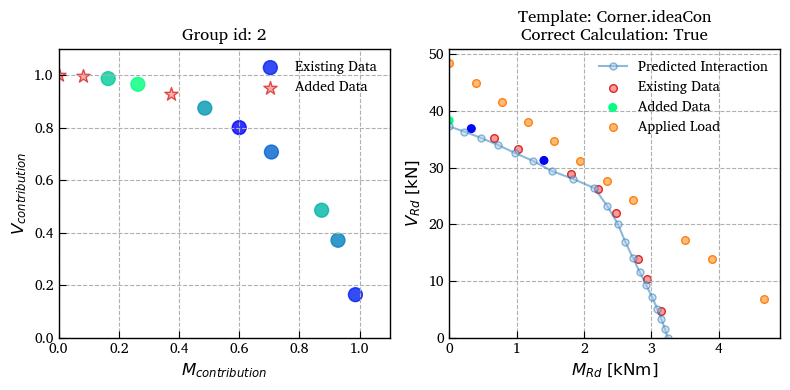

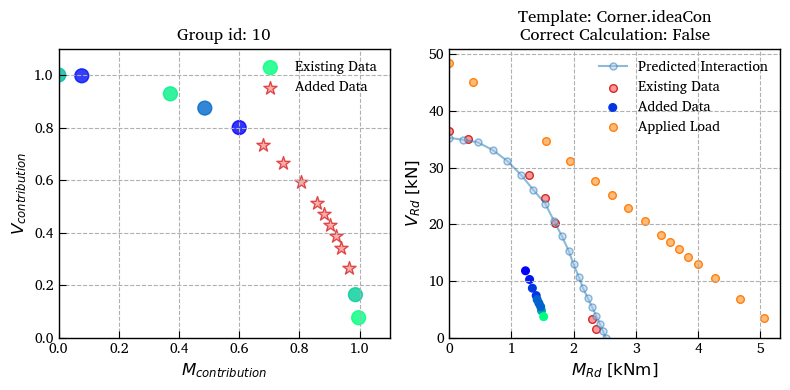

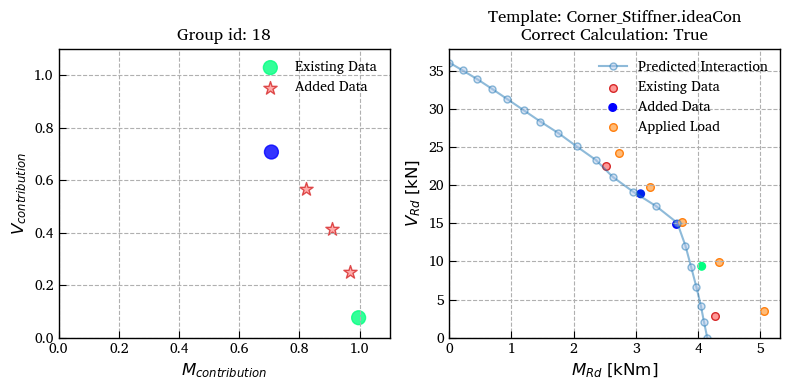

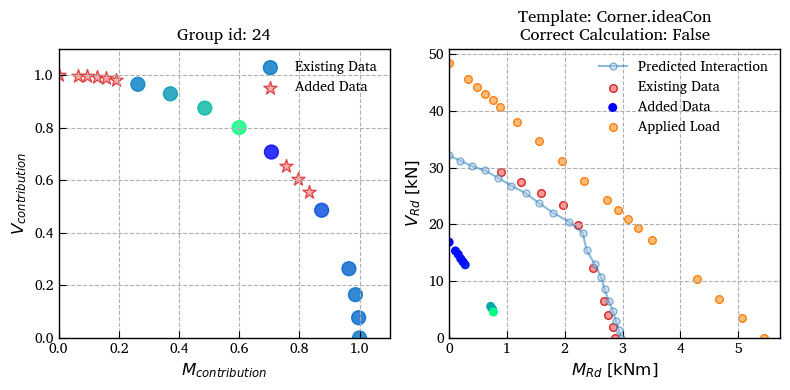

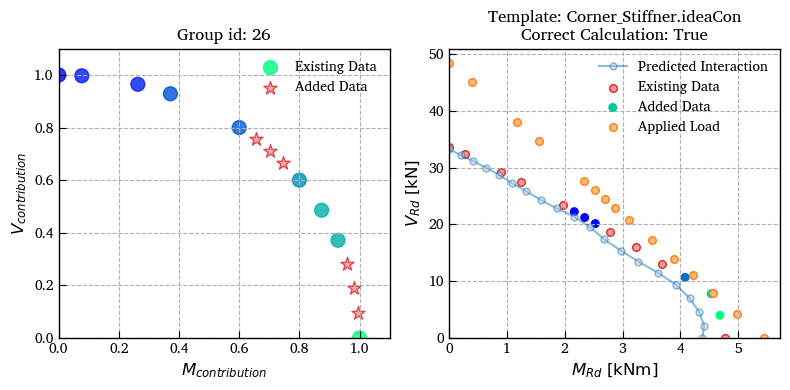

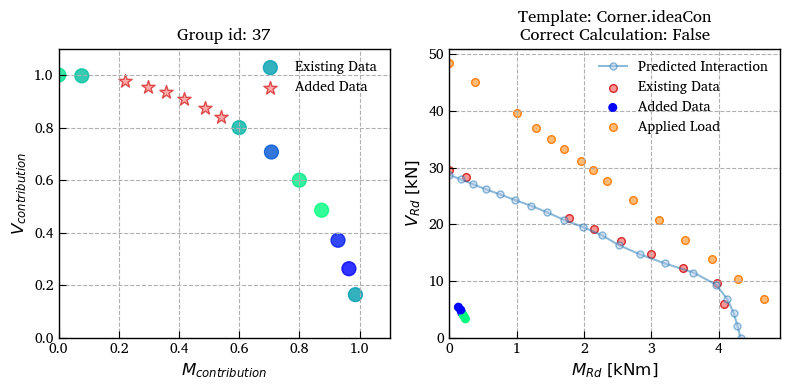

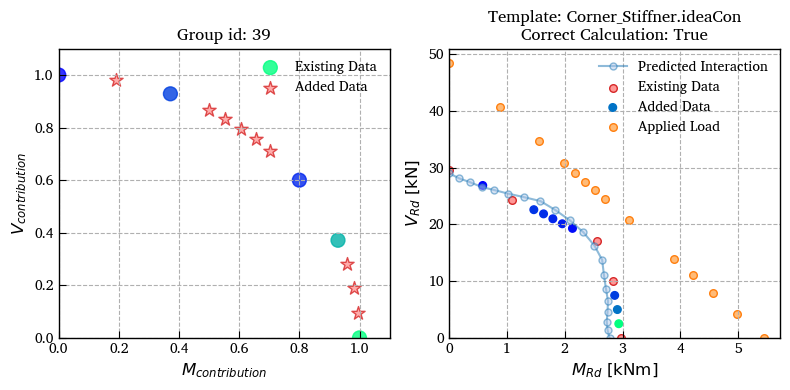

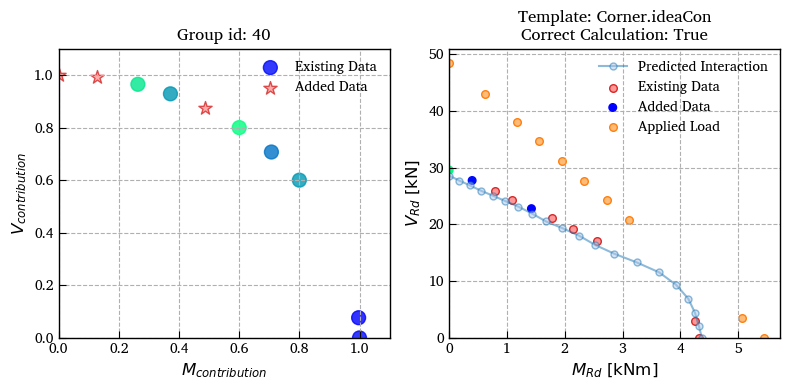

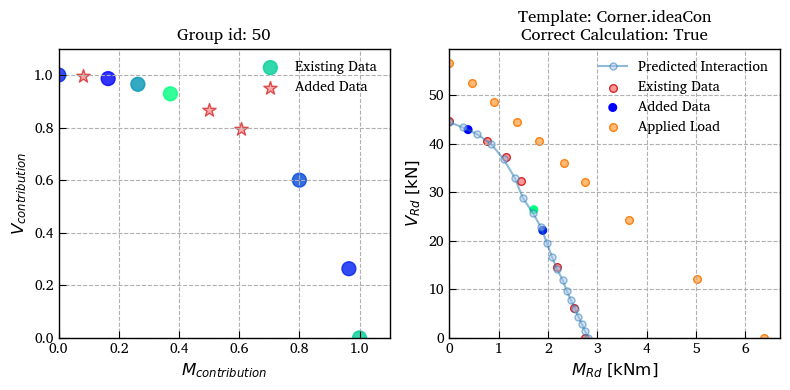

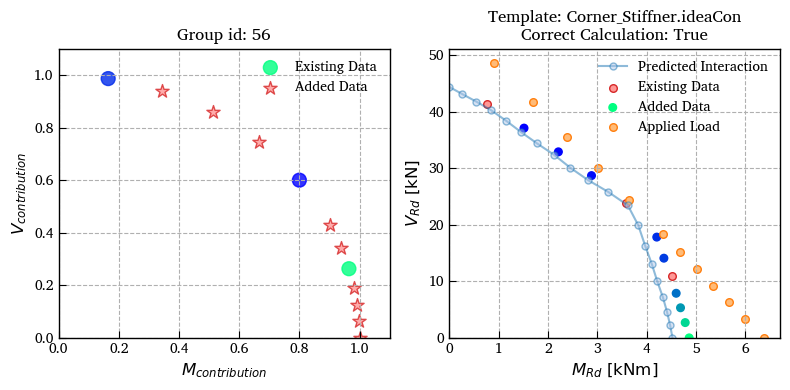

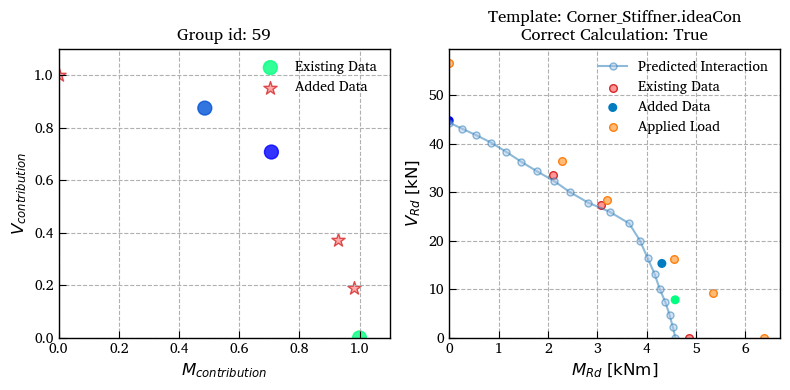

In [46]:
n_before = len(df_full)
counter = 0
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 10:
            break
        else:
            counter += 1

        M_contribution = df_AL.loc[group]['M_contribution'].values
        V_contribution = df_AL.loc[group]['V_contribution'].values
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        correct_calculation = filter_wrong_calculations(df_group)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths

        fig, axs = plt.subplots(1,2,figsize=(8, 4))
        ax = axs[0]
        ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
                    label='Existing Data',
                    c=np.abs(error_before[np.array(group)[mask_before]]),
                    cmap='winter',
                    #vmin=0,
                    alpha=0.8,
                    s=100)
        ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
                    label='Added Data',
                    marker='*',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=0.8,
                    s=100)
        ax.set_xlabel(r'$M_{contribution}$')
        ax.set_ylabel(r'$V_{contribution}$')
        ax.grid(True, linestyle='--', zorder=0)
        ax.set_title(f"Group id: {group_id}")
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.legend()

        ax = axs[1]
        ax.plot(M_Rd_pred, V_Rd_pred, 
                    label='Predicted Interaction',
                    marker='o',
                    c=plot_params.morecolors[0],
                    markerfacecolor=plot_params.morecolors[1],
                    markeredgecolor=plot_params.morecolors[0],
                    alpha=0.5,
                    markersize=5)

        ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
                    label='Existing Data',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
                    label='Added Data',
                    c=rel_deviation,
                    cmap='winter',
                    #vmin=0,
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M'].values, df_group['V'].values,
                    label='Applied Load',
                    facecolor=plot_params.morecolors[3],
                    edgecolor=plot_params.morecolors[2],
                    s=30)
        
        ax.set_title(f"Template: {df_AL.loc[group[-1]]['template']}\nCorrect Calculation: {correct_calculation}")

        ax.set_xlabel(plot_params.feature_labels['M_Rd'])
        ax.set_ylabel(plot_params.feature_labels['V_Rd'])
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle='--', zorder=0)
        ax.legend()
        #ax.set_aspect('equal', adjustable='box')

        plt.tight_layout()
        plt.show()

### Analyse Errors

In [56]:
n_before = len(df_full)
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        M_Rd_calc = df_group['M_Rd'].values
        V_Rd_calc = df_group['V_Rd'].values

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([M_Rd_calc[mask_added], V_Rd_calc[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths
        df_AL.loc[np.array(group)[mask_added], 'rel_distance_to_curve'] = rel_deviation

        dist_to_data = np.zeros(len(mask_added))
        for i in range(len(mask_added)):
            point = added_resistances[i]
            points = np.array([M_Rd_calc[mask_before], V_Rd_calc[mask_before]]).T
            distances = np.linalg.norm(points - point, axis=1)
            closest_id = np.argmin(distances)
            dist_to_data[i] = np.min(distances) / np.linalg.norm(points[closest_id])

        df_AL.loc[np.array(group)[mask_added], 'rel_distance_to_data'] = dist_to_data

        valid = (rel_deviation > 0.1) & (dist_to_data > 0.1)
        valid = ~valid
        valid = np.all(valid)

        df_AL.loc[np.array(group)[mask_added], 'valid'] = valid

In [57]:
df_error = df_AL[~np.isnan(df_AL['rel_distance_to_curve'])].copy()

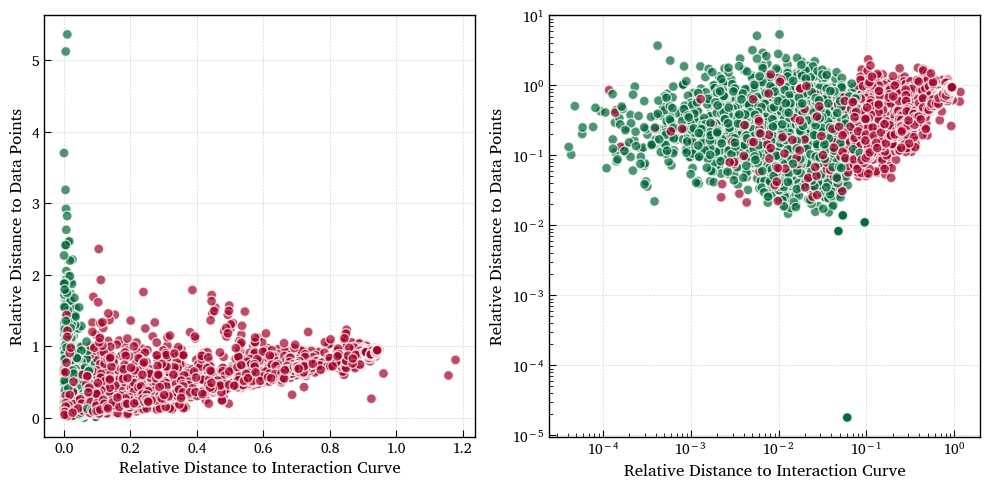

In [61]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))

axs[0].scatter(df_error['rel_distance_to_curve'], df_error['rel_distance_to_data'],
            c=df_error['valid'].values, cmap='RdYlGn', s=50, edgecolor='white', alpha=0.7, zorder=2)
axs[0].set_xlabel('Relative Distance to Interaction Curve')
axs[0].set_ylabel('Relative Distance to Data Points')
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

axs[1].scatter(df_error['rel_distance_to_curve'], df_error['rel_distance_to_data'],
            c=df_error['valid'].values, cmap='RdYlGn', s=50, edgecolor='white', alpha=0.7, zorder=2)
axs[1].set_xlabel('Relative Distance to Interaction Curve')
axs[1].set_ylabel('Relative Distance to Data Points')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()

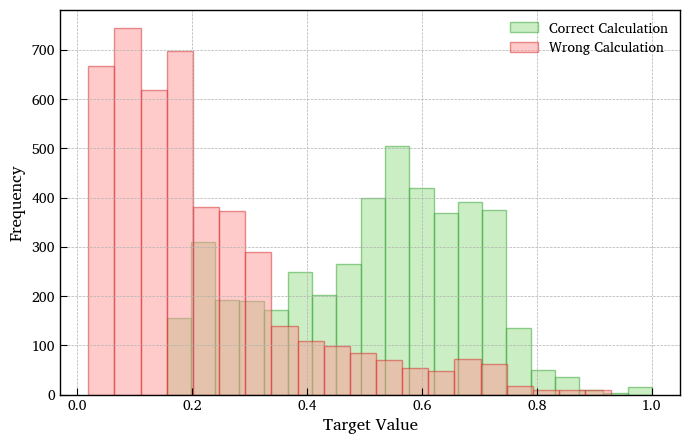

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.hist(df_error[df_error['valid']==True]['target'], bins =20, 
         edgecolor=plot_params.morecolors[4], 
         facecolor=plot_params.morecolors[5],
         alpha=0.5, label='Correct Calculation')

plt.hist(df_error[df_error['valid']==False]['target'], bins =20,
         edgecolor=plot_params.morecolors[6], 
         facecolor=plot_params.morecolors[7],
         alpha=0.5, label='Wrong Calculation')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [50]:
print(f"Valid Profiles: {len(df_error[df_error['valid']==True])}, Invalid Profiles: {len(df_error[df_error['valid']==False])}")

Valid Profiles: 4446, Invalid Profiles: 4554


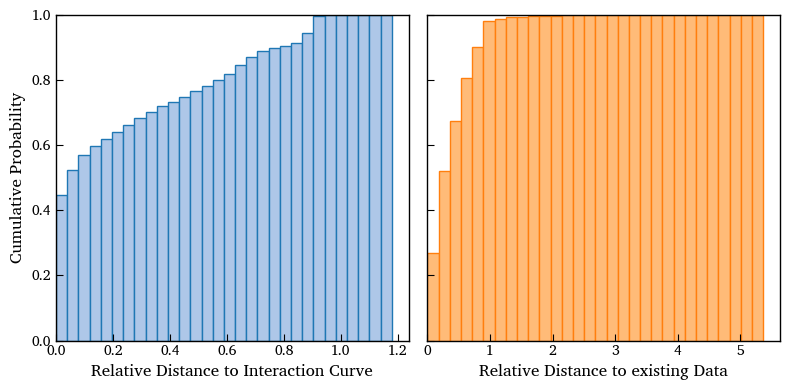

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axs[0].hist(df_error['rel_distance_to_curve'], bins=30, 
            edgecolor=plot_params.morecolors[0], 
            facecolor=plot_params.morecolors[1],
            alpha=1.0, cumulative=True, density=True,
            label='Relative Distance to Interaction Curve')

axs[1].hist(df_error['rel_distance_to_data'], bins=30, 
            edgecolor=plot_params.morecolors[2], 
            facecolor=plot_params.morecolors[3],
            alpha=1.0, cumulative=True, density=True,
            label='Relative Distance to Interaction Curve')

axs[0].set_xlabel('Relative Distance to Interaction Curve')
axs[0].set_ylabel('Cumulative Probability')
axs[1].set_xlabel('Relative Distance to existing Data')
axs[0].set_xlim(0, None)
axs[1].set_xlim(0, None)
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()


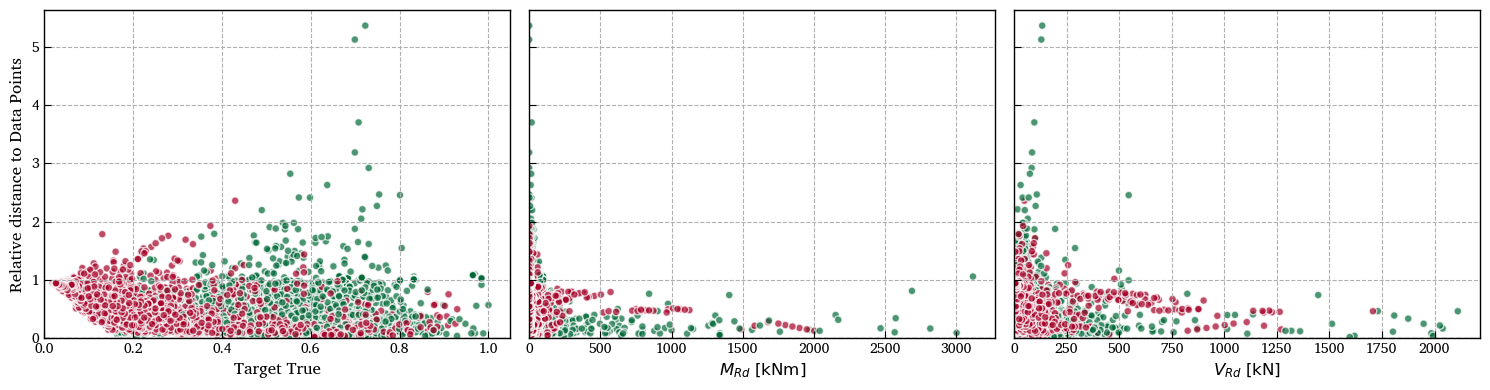

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['target'], df_error['rel_distance_to_data'],
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Target True')
axs[0].set_ylabel('Relative distance to Data Points')

axs[1].scatter(df_error['M_Rd'], df_error['rel_distance_to_data'],
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel(plot_params.feature_labels['M_Rd'])

axs[2].scatter(df_error['V_Rd'], df_error['rel_distance_to_data'],
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['V_Rd'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

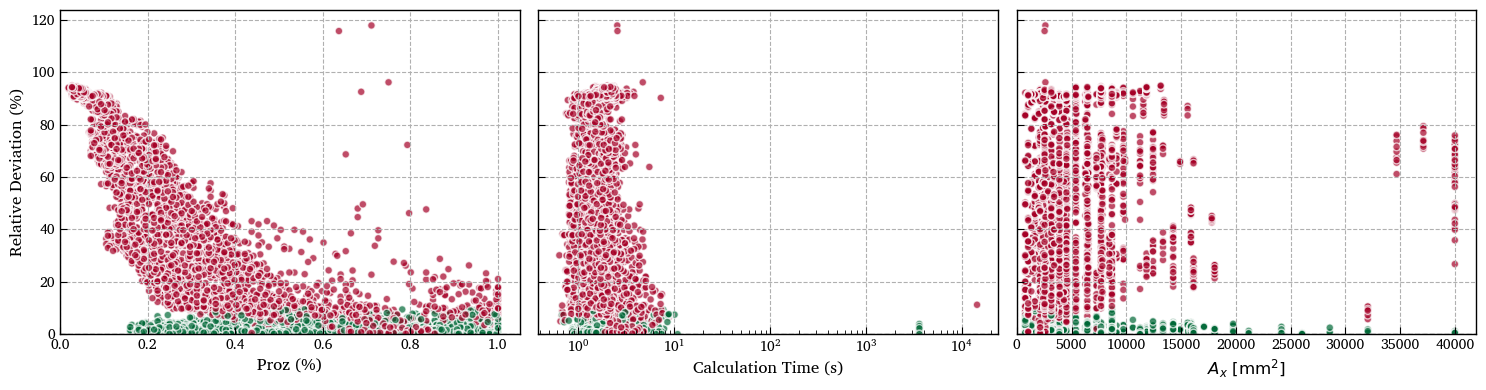

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['proz'], df_error['rel_distance_to_curve']*100,
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Proz (%)')
axs[0].set_ylabel('Relative Deviation (%)')

axs[1].scatter(df_error['calculation_time'], df_error['rel_distance_to_curve']*100,
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel('Calculation Time (s)')
axs[1].set_xscale('log')

axs[2].scatter(df_error['A_x'], df_error['rel_distance_to_curve']*100,
               c=df_error['valid'].values, cmap='RdYlGn', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['A_x'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

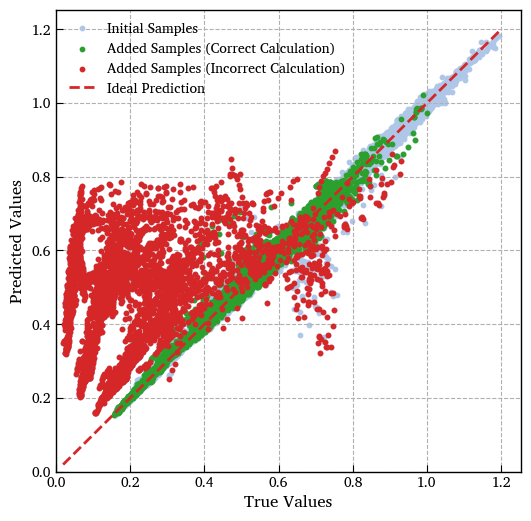

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[1],
            s=10,
            zorder=0,
            alpha=1.0
            )

plt.scatter(y_truth_before[ids_added[df_error['valid']==True]], y_preds_before[ids_added[df_error['valid']==True]],
               label='Added Samples (Correct Calculation)',
            facecolor=plot_params.morecolors[4],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

plt.scatter(y_truth_before[ids_added[df_error['valid']==False]], y_preds_before[ids_added[df_error['valid']==False]],
               label='Added Samples (Incorrect Calculation)',
            facecolor=plot_params.morecolors[6],
            edgecolor=plot_params.morecolors[6],
            s=10,
            zorder=2
            )

plt.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', zorder=0)
plt.xlim(0, None)
plt.ylim(0, None)

plt.legend()
plt.show()

#### Inspect calculation error on large load capacities

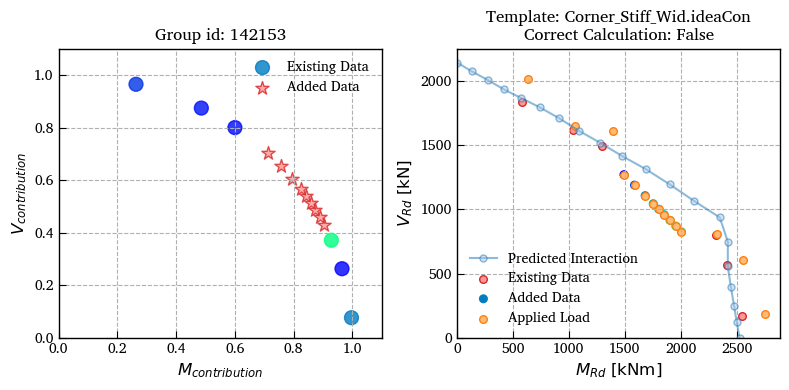

In [99]:
id = df_error[df_error['valid']==False].iloc[np.argmax(df_error[df_error['valid']==False]['M_Rd'])].name
group_id = df_AL.loc[id]['group_id']
group = np.array(identical_groups[group_id])

M_contribution = df_AL.loc[group]['M_contribution'].values
V_contribution = df_AL.loc[group]['V_contribution'].values

mask_before = np.where(np.array(group) < n_before)[0]
mask_added = np.where(np.array(group) >= n_before)[0]

base_profile = df_AL.loc[group[0]].copy()
df_group = df_AL.loc[group].copy()
M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

correct_calculation = filter_wrong_calculations(df_group)

interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
errors, closest_points = calculate_error(
    interaction_curve,
    added_resistances
)

vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

rel_deviation = errors / vector_lengths

fig, axs = plt.subplots(1,2,figsize=(8, 4))
ax = axs[0]
ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
            label='Existing Data',
            c=np.abs(error_before[np.array(group)[mask_before]]),
            cmap='winter',
            #vmin=0,
            alpha=0.8,
            s=100)
ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
            label='Added Data',
            marker='*',
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            alpha=0.8,
            s=100)
ax.set_xlabel(r'$M_{contribution}$')
ax.set_ylabel(r'$V_{contribution}$')
ax.grid(True, linestyle='--', zorder=0)
ax.set_title(f"Group id: {group_id}")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.legend()

ax = axs[1]
ax.plot(M_Rd_pred, V_Rd_pred, 
            label='Predicted Interaction',
            marker='o',
            c=plot_params.morecolors[0],
            markerfacecolor=plot_params.morecolors[1],
            markeredgecolor=plot_params.morecolors[0],
            alpha=0.5,
            markersize=5)

ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
            label='Existing Data',
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            alpha=1.0,
            s=30)
ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
            label='Added Data',
            c=rel_deviation,
            cmap='winter',
            #vmin=0,
            alpha=1.0,
            s=30)
ax.scatter(df_group['M'].values, df_group['V'].values,
            label='Applied Load',
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            s=30)

ax.set_title(f"Template: {df_AL.loc[group[-1]]['template']}\nCorrect Calculation: {correct_calculation}")

ax.set_xlabel(plot_params.feature_labels['M_Rd'])
ax.set_ylabel(plot_params.feature_labels['V_Rd'])
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid(True, linestyle='--', zorder=0)
ax.legend()
#ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Correlations

In [64]:
correlations = df_AL[~np.isnan(df_AL['rel_distance_to_curve'])].select_dtypes(include='number').corr()['rel_distance_to_curve'].sort_values(ascending=False)
print(correlations)

rel_distance_to_curve    1.000000
rel_distance_to_data     0.592587
Gamma                    0.454388
iteration                0.383554
Offset_Idea              0.278502
h_x                      0.163339
tw_x                     0.157222
h_y                      0.156607
tw_y                     0.145716
b_y                      0.139654
b_x                      0.139544
tf_x                     0.136800
A_x                      0.133305
V                        0.131652
tf_y                     0.131320
Av_x                     0.130987
A_y                      0.123896
Av_y                     0.122454
Vpl_x                    0.121630
group_id                 0.116274
Vpl_y                    0.114330
Wply_x                   0.104896
Wely_x                   0.104847
Mpl_x                    0.099654
Wely_y                   0.094996
Wply_y                   0.094948
Iy_x                     0.092062
Mpl_y                    0.091119
Iy_y                     0.080489
M             

#### Random Forest

In [65]:
X = df_error.select_dtypes(include='number').copy()
y = df_error['valid'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = XGBRFClassifier()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9778


In [66]:
importances = forest.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [67]:
importance_df

,Feature,Importance
53,rel_distance_to_curve,0.497642
45,target,0.145025
38,proz,0.080083
26,Gamma,0.031943
44,M_norm,0.025602
43,V_norm,0.014164
18,Av_y,0.012547
21,Wply_y,0.010674
25,Mpl_y,0.009728
20,Wely_y,0.009340


#### Random Forest Classifier with only feature data

In [98]:
X = df_error[model.features].select_dtypes(include='number').copy()
y = df_error['valid'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = XGBRFClassifier(n_estimators=1000, max_depth=10, random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9800


In [99]:
X_eval = df_full[model.features].select_dtypes(include='number').copy()
y_pred = forest.predict(X_eval)

In [129]:
df_full_filtered = df_full.copy()
df_full_filtered['validity_prediction'] = y_pred
df_full_filtered = df_full_filtered[df_full_filtered['validity_prediction'] == 1]

In [130]:
with open(r'Saved Variables\RF_calculation_validation.pkl', 'wb') as f:
    pickle.dump(forest, f)

In [131]:
df_full_filtered.to_csv(os.path.join(directory.root, "Data", "df_full_filtered.csv"), index=True)

### Uncertainty

In [402]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_added, num_samples=200)
uncertainty_added = mcd_std.flatten() / mcd_mean.flatten()

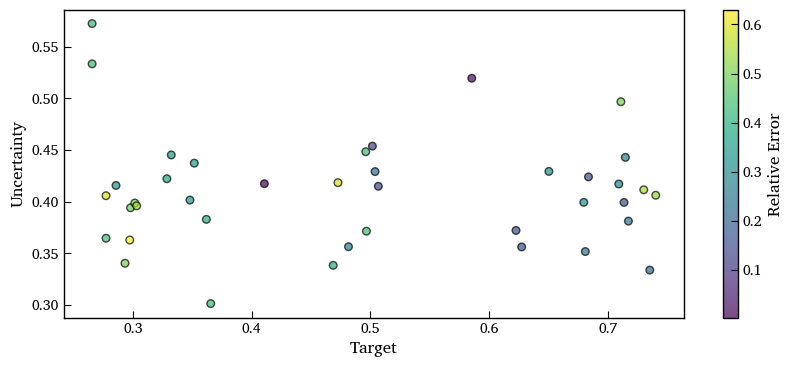

In [403]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(df_added['target'], uncertainty_added, label='Added Data',
            c=error_added, cmap='viridis', edgecolor='black', s=30, alpha=0.7)

plt.colorbar(label='Relative Error')
plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

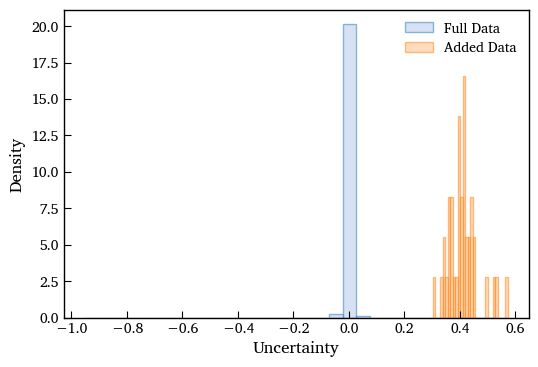

In [404]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=30,
         edgecolor=plot_params.morecolors[0], 
         facecolor=plot_params.morecolors[1], 
         alpha=0.5, label='Full Data',
         density=True)

plt.hist(uncertainty_added, bins=30, 
         edgecolor=plot_params.morecolors[2], 
         facecolor=plot_params.morecolors[3], 
         alpha=0.5, label='Added Data',
         density=True)

plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')

plt.show()

## Active Learning (with Filter)

In [ ]:
df_full_filtered = pd.read_csv(os.path.join(directory.root, "Data", "df_full_filtered.csv"), index_col=0)

In [ ]:
original_ids = df_full_filtered.index.copy()
df_full_filtered.reset_index(drop=True, inplace=True)

In [ ]:
model_AL = copy.deepcopy(model)
df_AL = df_full_filtered.copy()

df_AL.reset_index(drop=True, inplace=True)

df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [113]:
iterations = 1
groups_per_iter = 30
add_per_group = 2

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 60
Added Samples: 60


In [114]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [115]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 10, 5)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 5
Total Epochs: 5


In [116]:
save_interim_results = True

model_name = "DNN_Model_AL_Finetuned_FilterOn"
database_filename = "Extended_Database_FilterOn.csv"

MODEL_SAVE_PATH = os.path.join(directory.root, "Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

DATA_SAVE_FILE = os.path.join(directory.root, "Data", database_filename)

In [117]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_AL)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            #print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        get_MV(new_profiles)

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in unique_templates:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,df_new_profiles,profile_id)
            end_time = time.time()

            df_new_profiles.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1.0:
                results, loads, applied_percentage = underloaded(applied_percentage,df_new_profiles,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save_interim_results:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_filteron_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)

*** Iteration 1/1 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 13597)
   Processing Group 3.33% (Group id: 1545)
   Processing Group 6.67% (Group id: 1297)
   Processing Group 10.00% (Group id: 5353)
   Processing Group 13.33% (Group id: 6395)
   Processing Group 16.67% (Group id: 3325)
   Processing Group 20.00% (Group id: 3386)
   Processing Group 23.33% (Group id: 25882)
   Processing Group 26.67% (Group id: 13028)
   Processing Group 30.00% (Group id: 349)
   Processing Group 33.33% (Group id: 20912)
   Processing Group 36.67% (Group id: 1519)
   Processing Group 40.00% (Group id: 1332)
   Processing Group 43.33% (Group id: 13036)
   Processing Group 46.67% (Group id: 13001)
   Processing Group 50.00% (Group id: 3094)
   Processing Group 53.33% (Group id: 11656)
   Processing Group 56.67% (Group id: 26774)
   Processing Group 60.00% (Group id: 1748)
   Processing Group 63.33% (Group id: 3062)
   Processing Group 66.67% (Group id: 4876)
   Processing Group 70.00% (Grou

In [119]:
df_AL.to_csv(DATA_SAVE_FILE, index=True)

In [120]:
model_AL.save(MODEL_SAVE_FILE)

Model saved to: c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\Saved Models\DNN_Model_AL_Finetuned_FilterOn\DNN_Model_AL_Finetuned_FilterOn.pth


In [123]:
ids_added = np.array(list(df_AL.loc[len(df_full_filtered):].index))
ids_before = np.array(list(df_full_filtered.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds, _ = model.predict(df_AL)
y_truth = df_AL['target'].values

y_preds = y_preds.numpy().flatten()

# Calculate relative error
re_error = np.abs((y_preds - y_truth) / y_truth+1e-8)

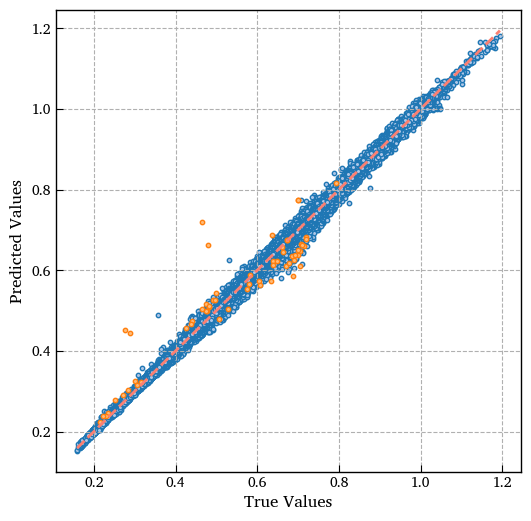

In [127]:
fig, axs = plt.subplots(figsize=(6, 6))

plt.scatter(y_truth[ids_before], y_preds[ids_before],
            label='Initial Samples',
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=0,
            alpha=1.0
            )

plt.scatter(y_truth[ids_added], y_preds[ids_added],
            label='Added Samples',
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            s=10,
            zorder=2
            )

plt.plot([y_truth.min(), y_truth.max()],
            [y_truth.min(), y_truth.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

plt.grid(True, linestyle='--', zorder=0)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()